### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

In [4]:
import coldic as cd
reload(cd)

<module 'coldic' from '/gpfs/scratch/mep22dku/windEval/plottingCode/coldic.py'>

In [5]:
cd.prod['UKESM']['col']

'k'

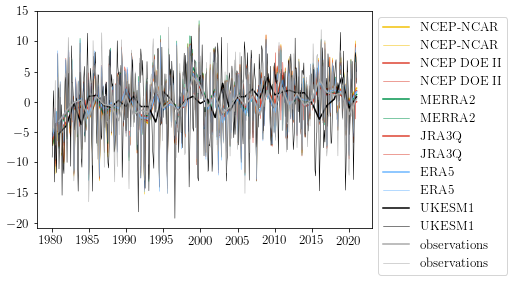

In [6]:
prods = ['NCEP-NCAR','NCEP-DOE','MERRA','JRA','ERA5','UKESM','obs']


# prods = ['UKESM']

plt.figure

for prod in prods:
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    
    wmn = w.resample(time='Y').mean()
    
    plt.plot(wmn.time,wmn.SAM, color = cd.prod[prod]['col'], label = cd.prod[prod]['fnam'])
    plt.plot(w.time,w.SAM, color = cd.prod[prod]['col'], label = cd.prod[prod]['fnam'], linewidth = 0.5)

plt.legend(bbox_to_anchor = [1, 1])
    
#     slp40S_a = w.slp40S - w.slp40S.mean()
#     slp65S_a = w.slp65S - w.slp65S.mean()
    
#     # plt.plot(w.time,slp40S_a,linestyle = ':',label = f'{prod}')
#     # plt.plot(w.time,slp65S_a,linestyle = '-',label = f'{prod}')   
#     plt.plot(w.time,slp40S_a-slp65S_a)
#     SAM = slp40S_a-slp65S_a
#     w['SAM'] = (('time'), SAM)
#     w.to_netcdf(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')

In [7]:

import pymannkendall as mk
from scipy import stats

def give_trends(ts_y):

    ts_x = np.arange(0,len(ts_y))
    trend, h, mk_p, z, Tau, s, var_s, mk_slope, intercept = mk.original_test(ts_y)
    lin_slope, intercept, r_value, lin_p, std_err = stats.linregress(ts_x,ts_y)
    
    return mk_slope, mk_p, lin_slope, lin_p


0.9504502565863768


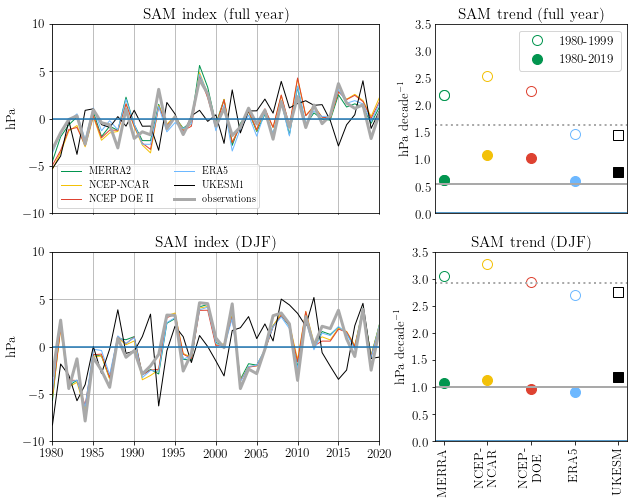

In [21]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fact = 1.2
# Create a figure and define the gridspec layout
fig = plt.figure(figsize=(7.5*fact, 6*fact))  # Adjust figure size as needed
gs = gridspec.GridSpec(2, 2, width_ratios=[1.7, 1], height_ratios=[1, 1])

# Left two subplots with a 1.6:1 aspect ratio
ax1 = fig.add_subplot(gs[0, 0])  # Top-left
ax2 = fig.add_subplot(gs[1, 0])  # Bottom-left
# Right two subplots that are square
ax3 = fig.add_subplot(gs[0, 1])  # Top-right
ax4 = fig.add_subplot(gs[1, 1])  # Bottom-right



prods = ['MERRA','NCEP-NCAR','NCEP-DOE','ERA5','UKESM','obs']


for prod in prods:
    
    

    mkz = 'o'; ms = 10; lw = 1
    if prod == 'obs':
        mkz = '*'; ms = 20; lw = 3
    if prod == 'UKESM':
        mkz = 's'; ms = 10
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wmn = w.resample(time='Y').mean()
    wmn2 = w.groupby('time.year').mean()
    
    ax1.plot(wmn2.year,wmn.SAM-np.mean(wmn.SAM.values), color = cd.prod[prod]['col'], label = cd.prod[prod]['fnam'], linewidth = lw)
    
## FY
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wmn = w.sel(time=(w['time.season'] == 'DJF')).resample(time='Y').mean()
    ax2.plot(wmn2.year,wmn.SAM-np.mean(wmn.SAM.values), color = cd.prod[prod]['col'], label = cd.prod[prod]['fnam'], linewidth = lw)
    
    wy = w.SAM.sel(time=(w['time.season'] == 'DJF')).sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    wym = np.mean(wy)
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)

prods = ['MERRA','NCEP-NCAR','NCEP-DOE','ERA5','UKESM','obs']
xa = np.arange(1,6,1)
print(np.random.rand(1)[0])


### DJF 
for i in range(0,6):

    prod = prods[i]
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wmn = w.resample(time='Y').mean()
    #axs[0].plot(wmn2.year,wmn.SAM, color = cd.prod[prod]['col'], label = cd.prod[prod]['fnam'], linewidth = lw)
    
    
    wy = w.SAM.sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    wym = np.mean(wy)
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    
    mkz = 'o'; ms = 10
    if prod == 'obs':
        mkz = '*'; ms = 20
    if prod == 'UKESM':
        mkz = 's'; ms = 10
    if prod != 'obs':
        ax3.plot(i, lin_slope*10, color = 'w', marker = mkz, markersize = ms, markeredgecolor = cd.prod[prod]['col'])
    if prod == 'MERRA':
        ax3.plot(i, lin_slope*10, color = 'w', marker = mkz, markersize = ms, \
                 markeredgecolor = cd.prod[prod]['col'], label = '1980-1999')
    
    if prod == 'obs':
        ax3.axhline(y = lin_slope*10, color = cd.prod[prod]['col'], linewidth = 2, linestyle = ':')

        
    wy = w.SAM.sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    wym = np.mean(wy)
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    
    mkz = 'o'; ms = 10
    if prod == 'obs':
        mkz = '*'; ms = 20
    if prod == 'UKESM':
        mkz = 's'; ms = 10
    
    if prod != 'obs':
        ax3.plot(i, lin_slope*10, color = cd.prod[prod]['col'], marker = mkz, markersize = ms, markeredgecolor = cd.prod[prod]['col'])
    if prod == 'MERRA':
        ax3.plot(i, lin_slope*10, color = cd.prod[prod]['col'], marker = mkz, markersize = ms, \
                 markeredgecolor = cd.prod[prod]['col'], label = '1980-2019', linewidth = 0)

    
    if prod == 'obs':
        ax3.axhline(y = lin_slope*10, color = cd.prod[prod]['col'], linewidth = 2, linestyle = '-')



### DJF 
for i in range(0,6):

    prod = prods[i]
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wmn = w.sel(time=(w['time.season'] == 'DJF')).resample(time='Y').mean()
    #axs[0].plot(wmn2.year,wmn.SAM, color = cd.prod[prod]['col'], label = cd.prod[prod]['fnam'], linewidth = lw)
    
    
    wy = w.SAM.sel(time=(w['time.season'] == 'DJF')).sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    wym = np.mean(wy)
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    
    mkz = 'o'; ms = 10
    if prod == 'obs':
        mkz = '*'; ms = 20
    if prod == 'UKESM':
        mkz = 's'; ms = 10
    if prod != 'obs':
        ax4.plot(i, lin_slope*10, color = 'w', marker = mkz, markersize = ms, markeredgecolor = cd.prod[prod]['col'])

    
    if prod == 'obs':
        ax4.axhline(y = lin_slope*10, color = cd.prod[prod]['col'], linewidth = 2, linestyle = ':')
 
    wy = w.SAM.sel(time=(w['time.season'] == 'DJF')).sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    wym = np.mean(wy)
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    
    mkz = 'o'; ms = 10
    if prod == 'obs':
        mkz = '*'; ms = 20
    if prod == 'UKESM':
        mkz = 's'; ms = 10
    
    if prod != 'obs':
        ax4.plot(i, lin_slope*10, color = cd.prod[prod]['col'], marker = mkz, markersize = ms, markeredgecolor = cd.prod[prod]['col'])

    
    if prod == 'obs':
        ax4.axhline(y = lin_slope*10, color = cd.prod[prod]['col'], linewidth = 2, linestyle = '-')

prods2 = ['MERRA','NCEP-\nNCAR','NCEP-\nDOE','ERA5','UKESM','obs']
        
q = ax4.set_xticks(np.arange(0,5))
q = ax4.set_xticklabels(prods2[0:5], rotation = 90)    

ax1.axhline(y = 0)
ax3.axhline(y = 0)
ax2.axhline(y = 0)
ax4.axhline(y = 0)
# ax3.axvline(x = 0)
# ax4.axvline(x = 0)

ax1.set_xlim([1980,2020])
ax2.set_xlim([1980,2020])

ax1.set_title('SAM index (full year)')
ax3.set_title('SAM trend (full year)')
ax2.set_title('SAM index (DJF)')
ax4.set_title('SAM trend (DJF)')
ax3.tick_params(direction='out', length=0, width=2, colors='k')

ax2.set_title('SAM index (DJF)') 
ax1.set_title('SAM index (full year)')
ax1.grid()
ax2.grid()
ax1.set_ylabel('hPa')
ax2.set_ylabel('hPa')
ax1.set_xticklabels([])
ax1.tick_params(axis='x', length=1, width=1)
ax1.set_xlim([1980,2020])
ax2.set_xlim([1980,2020])
ax1.set_ylim([-10,10])
ax2.set_ylim([-10,10])

ax3.set_ylim([0,3.5])
ax4.set_ylim([0,3.5])

ax1.legend(ncol = 2, fontsize = 10)
ax3.legend(loc = 'upper right')


ax1.set_ylabel('hPa')
ax2.set_ylabel('hPa')
ax3.set_ylabel('hPa decade$^{-1}$')
ax4.set_ylabel('hPa decade$^{-1}$')
# ax3.set_xlabel('hPa')
ax3.set_xticklabels([])



# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

fig.savefig('./plts/Fig-SAM.jpg', dpi = 300, bbox_inches='tight')

In [22]:
dss = ['ERA5','NCEP-NCAR','MERRA','NCEP-DOE','UKESM','obs']
# tdar = [era_ts, ncar_ts, merra_ts, doe_ts,  ukesm_ts]

data = np.zeros([2,6])
sig = np.zeros([2,6])
for i in range(0,6):
    
    prod = dss[i]
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wy = w.SAM.sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    data[0,i] = lin_slope* 10
    sig[0,i] = lin_p
    

    # wy = w.SAM.sel(time=(w['time.season'] == 'DJF').\
    #                sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    # mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    # data[1,i] = lin_slope* 10
    # sig[1,i] = lin_p
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'DJF'))
    wq = wy.sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wq)
    data[1,i] = lin_slope* 10
    sig[1,i] = lin_p    


            
    i = i+1
    

df = pd.DataFrame(data, columns=['ERA5','NCEP-NCAR','MERRA','NCEP-DOE','UKESM','obs'],\
                  index  = ['full year','DJF'])
df2 = pd.DataFrame(sig, columns=['ERA5','NCEP-NCAR','MERRA','NCEP-DOE','UKESM','obs'],\
                  index  = ['full year','DJF'])

df.attrs = {"made in": 'plottingCode/Fig-SAM.ipynb'}
df.to_csv(f'./plts/SAM_trend.csv')
df2.attrs = {"made in": 'plottingCode/Fig-SAM.ipynb'}
df2.to_csv(f'./plts/SAM_trendsig.csv')

In [23]:
print(df)
print(df2)

               ERA5  NCEP-NCAR     MERRA  NCEP-DOE     UKESM       obs
full year  0.598824   1.087588  0.622691  1.023226  0.759696  0.547384
DJF        0.919548   1.137522  1.077942  0.977772  1.187331  1.001601
               ERA5  NCEP-NCAR     MERRA  NCEP-DOE     UKESM       obs
full year  0.018478   0.000078  0.017910  0.000093  0.004511  0.025704
DJF        0.009227   0.001967  0.003033  0.004988  0.004647  0.014975


In [11]:
dss = ['ERA5','NCEP-NCAR','MERRA','NCEP-DOE','UKESM','obs']
# tdar = [era_ts, ncar_ts, merra_ts, doe_ts,  ukesm_ts]

data = np.zeros([2,6])
sig = np.zeros([2,6])
for i in range(0,6):
    
    prod = dss[i]
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wy = w.SAM.sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    data[0,i] = lin_slope* 10
    sig[0,i] = lin_p
    

    # wy = w.SAM.sel(time=(w['time.season'] == 'DJF').\
    #                sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    # mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    # data[1,i] = lin_slope* 10
    # sig[1,i] = lin_p
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'DJF'))
    wq = wy.sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wq)
    data[1,i] = lin_slope* 10
    sig[1,i] = lin_p    


            
    i = i+1
    

df = pd.DataFrame(data, columns=['ERA5','NCEP-NCAR','MERRA','NCEP-DOE','UKESM','obs'],\
                  index  = ['full year','DJF'])
df2 = pd.DataFrame(sig, columns=['ERA5','NCEP-NCAR','MERRA','NCEP-DOE','UKESM','obs'],\
                  index  = ['full year','DJF'])

df.attrs = {"made in": 'plottingCode/Fig-SAM.ipynb'}
df.to_csv(f'./plts/SAM_trend_1980-1999.csv')
df2.attrs = {"made in": 'plottingCode/Fig-SAM.ipynb'}
df2.to_csv(f'./plts/SAM_trendsig_1980-1999.csv')

print(df)

               ERA5  NCEP-NCAR     MERRA  NCEP-DOE     UKESM       obs
full year  1.470678   2.536551  2.187429  2.259032  1.457858  1.636059
DJF        2.700948   3.281561  3.055131  2.945330  2.757183  2.931353


In [12]:
wspd_trend = pd.read_csv(f'./plts/mn_wspd_trend.csv', index_col=0)
wspd_sig = pd.read_csv(f'./plts/mn_wspd_trendsig.csv', index_col=0)

wspd_trend80 = pd.read_csv(f'./plts/mn_wspd_trend_1980-1999.csv', index_col=0)
wspd_sig80 = pd.read_csv(f'./plts/mn_wspd_trendsig_1980-1999.csv', index_col=0)

SAM_trend80 = pd.read_csv(f'./plts/SAM_trend_1980-1999.csv', index_col=0)
SAM_sig80 = pd.read_csv(f'./plts/SAM_trendsig_1980-1999.csv', index_col=0)

SAM_trend = pd.read_csv(f'./plts/SAM_trend.csv', index_col=0)
SAM_sig = pd.read_csv(f'./plts/SAM_trendsig.csv', index_col=0)

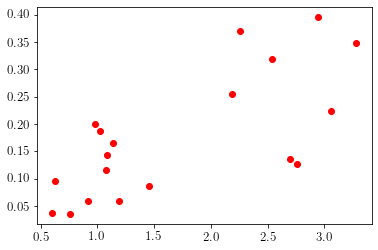

In [13]:
from scipy.stats import linregress

prods = ['MERRA','NCEP-NCAR','NCEP-DOE','ERA5','UKESM']#,'obs']

sams = []
winds = []

for i in range(0,5):
    x = SAM_trend.at['full year', f'{prods[i]}']
    xs = SAM_sig.at['full year', f'{prods[i]}']

    y = wspd_trend.at['full year', f'{prods[i]}']
    ys = wspd_sig.at['full year', f'{prods[i]}']
    

    if ((xs < 0.05) & (ys < 0.05)):
        sams.append(x)
        winds.append(y)
    
    x = SAM_trend80.at['full year', f'{prods[i]}']
    xs = SAM_sig80.at['full year', f'{prods[i]}']

    y = wspd_trend80.at['full year', f'{prods[i]}']
    ys = wspd_sig80.at['full year', f'{prods[i]}']
    

    if ((xs < 0.05) & (ys < 0.05)):
        sams.append(x)
        winds.append(y)
        

sams = np.array(sams)
winds = np.array(winds)

plt.plot(sams,winds,'ro')

slopeFY, interceptFY, r_valueFY, p_valueFY, std_err = linregress(sams, winds)

prods = ['MERRA','NCEP-NCAR','NCEP-DOE','ERA5','UKESM']#,'obs']

sams = []
winds = []

for i in range(0,5):
    x = SAM_trend.at['DJF', f'{prods[i]}']
    xs = SAM_sig.at['DJF', f'{prods[i]}']

    y = wspd_trend.at['DJF', f'{prods[i]}']
    ys = wspd_sig.at['DJF', f'{prods[i]}']
    

    if ((xs < 0.05) & (ys < 0.05)):
        sams.append(x)
        winds.append(y)
    
    x = SAM_trend80.at['DJF', f'{prods[i]}']
    xs = SAM_sig80.at['DJF', f'{prods[i]}']

    y = wspd_trend80.at['DJF', f'{prods[i]}']
    ys = wspd_sig80.at['DJF', f'{prods[i]}']
    

    if ((xs < 0.05) & (ys < 0.05)):
        sams.append(x)
        winds.append(y)
        

sams = np.array(sams)
winds = np.array(winds)

plt.plot(sams,winds,'ro')

slopeDJF, interceptDJF, r_valueDJF, p_valueDJF, std_err = linregress(sams, winds)


ERA5, sam sig 0.0547525283871871 wind sig 0.0443261698527855


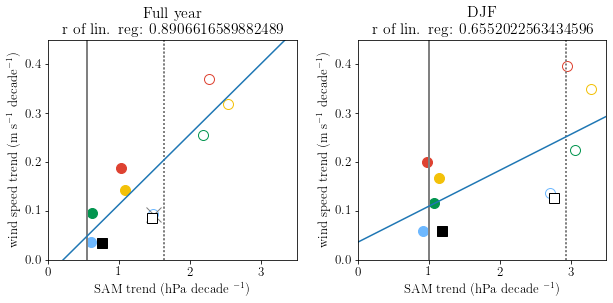

In [14]:
fact = 1.1
fig, axs = plt.subplots(1,2, figsize=(8*fact, 4*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

prods = ['MERRA','NCEP-NCAR','NCEP-DOE','ERA5','UKESM']#,'obs']
xa = np.arange(1,6,1)

for i in range(0,5):
    x = SAM_trend.at['full year', f'{prods[i]}']
    xs = SAM_sig.at['full year', f'{prods[i]}']

    y = wspd_trend.at['full year', f'{prods[i]}']
    ys = wspd_sig.at['full year', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10


    axs[0].plot(x, y, color = cd.prod[prods[i]]['col'], \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'])
    if ((xs > 0.05) | (ys > 0.05)):
        axs[0].plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
    
    
    #####
    
    x = SAM_trend80.at['full year', f'{prods[i]}']
    xs = SAM_sig80.at['full year', f'{prods[i]}']

    y = wspd_trend80.at['full year', f'{prods[i]}']
    ys = wspd_sig80.at['full year', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10

    axs[0].plot(x, y, color = 'w', \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'])
    
    if ((xs > 0.05) | (ys > 0.05)):
        axs[0].plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
        
        
#### DFJ
for i in range(0,5):
    x = SAM_trend.at['DJF', f'{prods[i]}']
    xs = SAM_sig.at['DJF', f'{prods[i]}']

    y = wspd_trend.at['DJF', f'{prods[i]}']
    ys = wspd_sig.at['DJF', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10


    axs[1].plot(x, y, color = cd.prod[prods[i]]['col'], \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'])
    if ((xs > 0.05) | (ys > 0.05)):
        axs[1].plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
    
    
    #####
    
    x = SAM_trend80.at['DJF', f'{prods[i]}']
    xs = SAM_sig80.at['DJF', f'{prods[i]}']

    y = wspd_trend80.at['DJF', f'{prods[i]}']
    ys = wspd_sig80.at['DJF', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10

    axs[1].plot(x, y, color = 'w', \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'])
    
    if ((xs > 0.05) | (ys > 0.05)):
        axs[1].plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
        
    obst = SAM_trend.at['DJF', 'obs']
    axs[1].axvline(obst, color = 'grey')
    obst = SAM_trend.at['full year', 'obs']
    axs[0].axvline(obst, color = 'grey')
    
    obst = SAM_trend80.at['DJF', 'obs']
    axs[1].axvline(obst, color = 'grey', linestyle = ':')
    obst = SAM_trend80.at['full year', 'obs']
    axs[0].axvline(obst, color = 'grey', linestyle = ':')
    
for i in range(0,2):
    axs[i].set_xlim([0,3.5])
    axs[i].set_ylim([0,0.45])
    axs[i].set_xlabel('SAM trend (hPa decade $^{-1}$)')
    axs[i].set_ylabel('wind speed trend (m s$^{-1}$ decade$^{-1}$)')
    axs[0].set_title('Full year')
    axs[1].set_title('DJF')
    
xar = np.arange(0,4,0.2)
yar = xar*slopeFY + interceptFY
axs[0].plot(xar,yar)

xar = np.arange(0,4,0.2)
yar = xar*slopeDJF + interceptDJF
axs[1].plot(xar,yar)

axs[0].set_title(f'Full year \n r of lin. reg: {r_valueFY}')
axs[1].set_title(f'DJF \n r of lin. reg: {r_valueDJF}')

plt.tight_layout()

ERA5, sam sig 0.0547525283871871 wind sig 0.0443261698527855


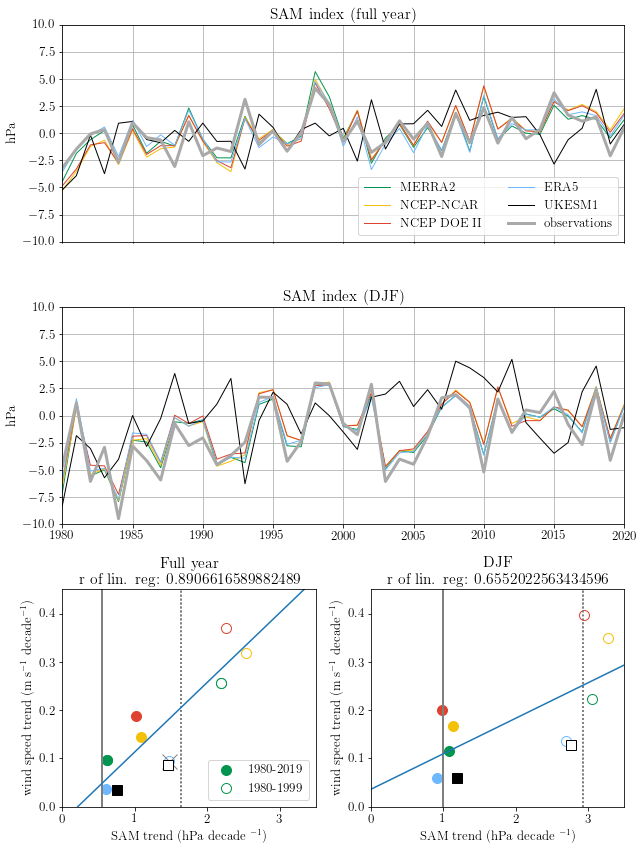

In [24]:
fact = 1.2
# Create a figure and define the gridspec layout
fig = plt.figure(figsize=(7.5*fact, 10*fact))  # Adjust figure size as needed
gs = gridspec.GridSpec(3, 2,)

# Left two subplots with a 1.6:1 aspect ratio
ax1 = fig.add_subplot(gs[0, :])  # Top-left
ax2 = fig.add_subplot(gs[1, :])  # Bottom-left
# Right two subplots that are square
ax3 = fig.add_subplot(gs[2, 0])  # Top-right
ax4 = fig.add_subplot(gs[2, 1])  # Bottom-right



########
axs = axs.ravel()

prods = ['MERRA','NCEP-NCAR','NCEP-DOE','ERA5','UKESM']#,'obs']
xa = np.arange(1,6,1)

for i in range(0,5):
    x = SAM_trend.at['full year', f'{prods[i]}']
    xs = SAM_sig.at['full year', f'{prods[i]}']

    y = wspd_trend.at['full year', f'{prods[i]}']
    ys = wspd_sig.at['full year', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10


    ax3.plot(x, y, color = cd.prod[prods[i]]['col'], \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'])
    if ((xs > 0.05) | (ys > 0.05)):
        ax3.plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
    
    if prods[i] == 'MERRA':
        ax3.plot(x, y, color = cd.prod[prods[i]]['col'], \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'], label = '1980-2019', linewidth = 0)    
    
    #####
    
    x = SAM_trend80.at['full year', f'{prods[i]}']
    xs = SAM_sig80.at['full year', f'{prods[i]}']

    y = wspd_trend80.at['full year', f'{prods[i]}']
    ys = wspd_sig80.at['full year', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10

    ax3.plot(x, y, color = 'w', \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'])
    
    if prods[i] == 'MERRA':
        ax3.plot(x, y, color = 'w', \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'], label = '1980-1999')
    

    if ((xs > 0.05) | (ys > 0.05)):
        ax3.plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
        
        
#### DFJ
for i in range(0,5):
    x = SAM_trend.at['DJF', f'{prods[i]}']
    xs = SAM_sig.at['DJF', f'{prods[i]}']

    y = wspd_trend.at['DJF', f'{prods[i]}']
    ys = wspd_sig.at['DJF', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10
    
    ax4.plot(x, y, color = cd.prod[prods[i]]['col'], \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'])
        

        
    if ((xs > 0.05) | (ys > 0.05)):
        ax4.plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
    
    
    #####
    
    x = SAM_trend80.at['DJF', f'{prods[i]}']
    xs = SAM_sig80.at['DJF', f'{prods[i]}']

    y = wspd_trend80.at['DJF', f'{prods[i]}']
    ys = wspd_sig80.at['DJF', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10

    ax4.plot(x, y, color = 'w', \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'])
    
    if ((xs > 0.05) | (ys > 0.05)):
        ax4.plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
        
    obst = SAM_trend.at['DJF', 'obs']
    ax4.axvline(obst, color = 'grey')
    obst = SAM_trend.at['full year', 'obs']
    ax3.axvline(obst, color = 'grey')
    
    obst = SAM_trend80.at['DJF', 'obs']
    ax4.axvline(obst, color = 'grey', linestyle = ':')
    obst = SAM_trend80.at['full year', 'obs']
    ax3.axvline(obst, color = 'grey', linestyle = ':')
    
for ax in [ax3, ax4]:
    ax.set_xlim([0,3.5])
    ax.set_ylim([0,0.45])
    ax.set_xlabel('SAM trend (hPa decade $^{-1}$)')
    ax.set_ylabel('wind speed trend (m s$^{-1}$ decade$^{-1}$)')
    ax3.set_title('Full year')
    ax4.set_title('DJF')
    
xar = np.arange(0,4,0.2)
yar = xar*slopeFY + interceptFY
ax3.plot(xar,yar)

xar = np.arange(0,4,0.2)
yar = xar*slopeDJF + interceptDJF
ax4.plot(xar,yar)

ax3.set_title(f'Full year \n r of lin. reg: {r_valueFY}')
ax4.set_title(f'DJF \n r of lin. reg: {r_valueDJF}')
ax3.legend()

#
prods = ['MERRA','NCEP-NCAR','NCEP-DOE','ERA5','UKESM','obs']


for prod in prods:
    
    

    mkz = 'o'; ms = 10; lw = 1
    if prod == 'obs':
        mkz = '*'; ms = 20; lw = 3
    if prod == 'UKESM':
        mkz = 's'; ms = 10
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wmn = w.resample(time='Y').mean()
    wmn2 = w.groupby('time.year').mean()
    ax1.plot(wmn2.year,wmn.SAM, color = cd.prod[prod]['col'], label = cd.prod[prod]['fnam'], linewidth = lw)
    
#     wy = w.SAM.sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
#     wym = np.mean(wy)
#     mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
#     if prod == 'obs':
#         ax3.plot(wym, lin_slope, color ='w', marker = mkz, \
#                  markersize = ms, markeredgecolor = cd.prod[prod]['col'], label = '1980-2000', linestyle = None)
#     ax3.plot(wym, lin_slope, color ='w', marker = mkz, \
#          markersize = ms, markeredgecolor = cd.prod[prod]['col'])
    
#     wy = w.SAM.sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
#     wym = np.mean(wy)
#     mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
#     if prod == 'obs':
#         ax3.plot(wym, lin_slope, color =cd.prod[prod]['col'], marker = mkz, markersize = ms,\
#                  markeredgecolor = cd.prod[prod]['col'], label = '1980-2020', linewidth = 0)   
#     ax3.plot(wym, lin_slope, color =cd.prod[prod]['col'], marker = mkz, markersize = ms, markeredgecolor = cd.prod[prod]['col'])    

## FY
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wmn = w.sel(time=(w['time.season'] == 'DJF')).resample(time='Y').mean()
    ax2.plot(wmn2.year,wmn.SAM, color = cd.prod[prod]['col'], label = cd.prod[prod]['fnam'], linewidth = lw)
    
    wy = w.SAM.sel(time=(w['time.season'] == 'DJF')).sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    wym = np.mean(wy)
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)

ax2.set_title('SAM index (DJF)') 
ax1.set_title('SAM index (full year)')
ax1.grid()
ax1.legend(loc = 'best', ncol = 2)
ax2.grid()
ax1.set_ylabel('hPa')
ax2.set_ylabel('hPa')
ax1.set_xticklabels([])
ax1.tick_params(axis='x', length=1, width=1)
ax1.set_xlim([1980,2020])
ax2.set_xlim([1980,2020])
ax1.set_ylim([-10,10])
ax2.set_ylim([-10,10])

plt.tight_layout()

fig.savefig('./plts/Fig-SAM.jpg', dpi = 300, bbox_inches='tight')

### smooth

ERA5, sam sig 0.0547525283871871 wind sig 0.0443261698527855


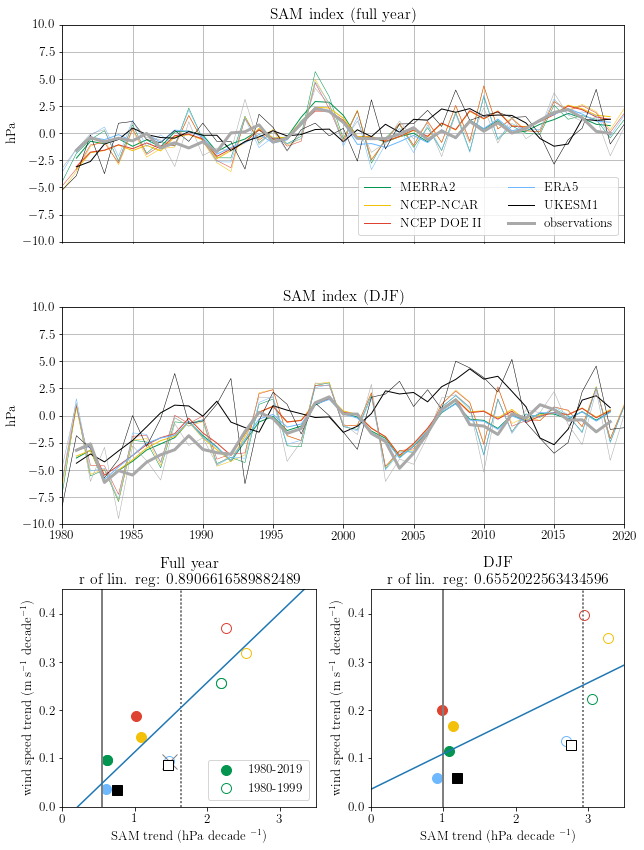

In [33]:
import sharedfunc as sf

fact = 1.2
# Create a figure and define the gridspec layout
fig = plt.figure(figsize=(7.5*fact, 10*fact))  # Adjust figure size as needed
gs = gridspec.GridSpec(3, 2,)

# Left two subplots with a 1.6:1 aspect ratio
ax1 = fig.add_subplot(gs[0, :])  # Top-left
ax2 = fig.add_subplot(gs[1, :])  # Bottom-left
# Right two subplots that are square
ax3 = fig.add_subplot(gs[2, 0])  # Top-right
ax4 = fig.add_subplot(gs[2, 1])  # Bottom-right



########
axs = axs.ravel()

prods = ['MERRA','NCEP-NCAR','NCEP-DOE','ERA5','UKESM']#,'obs']
xa = np.arange(1,6,1)

for i in range(0,5):
    x = SAM_trend.at['full year', f'{prods[i]}']
    xs = SAM_sig.at['full year', f'{prods[i]}']

    y = wspd_trend.at['full year', f'{prods[i]}']
    ys = wspd_sig.at['full year', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10


    ax3.plot(x, y, color = cd.prod[prods[i]]['col'], \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'])
    if ((xs > 0.05) | (ys > 0.05)):
        ax3.plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
    
    if prods[i] == 'MERRA':
        ax3.plot(x, y, color = cd.prod[prods[i]]['col'], \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'], label = '1980-2019', linewidth = 0)    
    
    #####
    
    x = SAM_trend80.at['full year', f'{prods[i]}']
    xs = SAM_sig80.at['full year', f'{prods[i]}']

    y = wspd_trend80.at['full year', f'{prods[i]}']
    ys = wspd_sig80.at['full year', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10

    ax3.plot(x, y, color = 'w', \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'])
    
    if prods[i] == 'MERRA':
        ax3.plot(x, y, color = 'w', \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'], label = '1980-1999')
    

    if ((xs > 0.05) | (ys > 0.05)):
        ax3.plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
        
        
#### DFJ
for i in range(0,5):
    x = SAM_trend.at['DJF', f'{prods[i]}']
    xs = SAM_sig.at['DJF', f'{prods[i]}']

    y = wspd_trend.at['DJF', f'{prods[i]}']
    ys = wspd_sig.at['DJF', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10
    
    ax4.plot(x, y, color = cd.prod[prods[i]]['col'], \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'])
        

        
    if ((xs > 0.05) | (ys > 0.05)):
        ax4.plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
    
    
    #####
    
    x = SAM_trend80.at['DJF', f'{prods[i]}']
    xs = SAM_sig80.at['DJF', f'{prods[i]}']

    y = wspd_trend80.at['DJF', f'{prods[i]}']
    ys = wspd_sig80.at['DJF', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10

    ax4.plot(x, y, color = 'w', \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'])
    
    if ((xs > 0.05) | (ys > 0.05)):
        ax4.plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
        
    obst = SAM_trend.at['DJF', 'obs']
    ax4.axvline(obst, color = 'grey')
    obst = SAM_trend.at['full year', 'obs']
    ax3.axvline(obst, color = 'grey')
    
    obst = SAM_trend80.at['DJF', 'obs']
    ax4.axvline(obst, color = 'grey', linestyle = ':')
    obst = SAM_trend80.at['full year', 'obs']
    ax3.axvline(obst, color = 'grey', linestyle = ':')
    
for ax in [ax3, ax4]:
    ax.set_xlim([0,3.5])
    ax.set_ylim([0,0.45])
    ax.set_xlabel('SAM trend (hPa decade $^{-1}$)')
    ax.set_ylabel('wind speed trend (m s$^{-1}$ decade$^{-1}$)')
    ax3.set_title('Full year')
    ax4.set_title('DJF')
    
xar = np.arange(0,4,0.2)
yar = xar*slopeFY + interceptFY
ax3.plot(xar,yar)

xar = np.arange(0,4,0.2)
yar = xar*slopeDJF + interceptDJF
ax4.plot(xar,yar)

ax3.set_title(f'Full year \n r of lin. reg: {r_valueFY}')
ax4.set_title(f'DJF \n r of lin. reg: {r_valueDJF}')
ax3.legend()

#
prods = ['MERRA','NCEP-NCAR','NCEP-DOE','ERA5','UKESM','obs']


for prod in prods:
    
    

    mkz = 'o'; ms = 10; lw = 1
    if prod == 'obs':
        mkz = '*'; ms = 20; lw = 3
    if prod == 'UKESM':
        mkz = 's'; ms = 10
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wmn = w.resample(time='Y').mean()
    wmn2 = w.groupby('time.year').mean()
    ax1.plot(wmn2.year,wmn.SAM, color = cd.prod[prod]['col'], linewidth = 0.5)
    ax1.plot(wmn2.year[1:-1],sf.moving_average(wmn.SAM), color = cd.prod[prod]['col'], label = cd.prod[prod]['fnam'], linewidth = lw)

    
## FY
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wmn = w.sel(time=(w['time.season'] == 'DJF')).resample(time='Y').mean()
    ax2.plot(wmn2.year,wmn.SAM, color = cd.prod[prod]['col'], linewidth = 0.5)
    ax2.plot(wmn2.year[1:-1],sf.moving_average(wmn.SAM), color = cd.prod[prod]['col'], label = cd.prod[prod]['fnam'], linewidth = lw)

    wy = w.SAM.sel(time=(w['time.season'] == 'DJF')).sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    wym = np.mean(wy)
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)

ax2.set_title('SAM index (DJF)') 
ax1.set_title('SAM index (full year)')
ax1.grid()
ax1.legend(loc = 'best', ncol = 2)
ax2.grid()
ax1.set_ylabel('hPa')
ax2.set_ylabel('hPa')
ax1.set_xticklabels([])
ax1.tick_params(axis='x', length=1, width=1)
ax1.set_xlim([1980,2020])
ax2.set_xlim([1980,2020])
ax1.set_ylim([-10,10])
ax2.set_ylim([-10,10])

plt.tight_layout()

#fig.savefig('./plts/Fig-SAM.jpg', dpi = 300, bbox_inches='tight')

In [16]:
prods = ['MERRA','NCEP-NCAR','NCEP-DOE','UKESM','obs',]


# prods = ['UKESM']

plt.figure

for prod in prods:
    print(prod)
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'DJF')).sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    print(f'1980-2000 DJF {lin_slope}, {lin_p}')  
    # wy = w.SAM.sel(time=(w['time.season'] == 'JJA')).sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    # mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    # print(f'1980-2000 JJA {lin_slope}, {lin_p}')      
    wy = w.SAM.sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    print(f'1980-2000 FY {lin_slope}, {lin_p}')      
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'DJF')).sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    print(f'1980-2020 DJF {lin_slope}, {lin_p}')  
    # wy = w.SAM.sel(time=(w['time.season'] == 'JJA')).sel(time=slice(f'1980-01-01', f'2020-12-31')).resample(time='Y').mean().values
    # mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    # print(f'1980-2020 JJA {lin_slope}, {lin_p}')      
    wy = w.SAM.sel(time=slice(f'1980-01-01', f'2020-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    print(f'1980-2020 FY {lin_slope}, {lin_p}')      
    
    print()


MERRA
1980-2000 DJF 0.30551311873433584, 0.008489522632414391
1980-2000 FY 0.21874292665257059, 0.008679314539389199
1980-2020 DJF 0.10779420487414056, 0.0030329481239159124
1980-2020 FY 0.062153135434814426, 0.013199656765519813

NCEP-NCAR
1980-2000 DJF 0.32815611959624114, 0.004706015664030562
1980-2000 FY 0.25365512924534933, 0.002455210633023773
1980-2020 DJF 0.11375215912402012, 0.001966842992161719
1980-2020 FY 0.10891200055332549, 3.6333125133727123e-05

NCEP-DOE
1980-2000 DJF 0.294532994204726, 0.0068862826064793724
1980-2000 FY 0.22590318503684567, 0.0036493807667002678
1980-2020 DJF 0.09777719396101854, 0.004987813358138302
1980-2020 FY 0.10137756484907887, 5.136488182339599e-05

UKESM
1980-2000 DJF 0.2757182604949887, 0.02002243280650989
1980-2000 FY 0.1457858121867172, 0.04445567453908017
1980-2020 DJF 0.11873312299679425, 0.004646616632742
1980-2020 FY 0.07339274598940164, 0.003986414623244331

obs
1980-2000 DJF 0.29313533834586525, 0.015449052170759984
1980-2000 FY 0.1636

## make dotgraph

0.7617450393257141


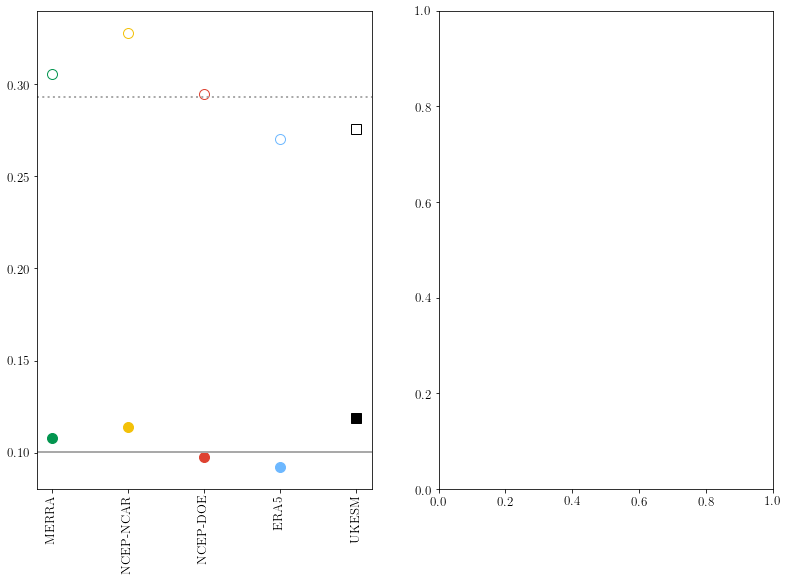

In [17]:

fact = 1.1
fig, axs = plt.subplots(1,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

prods = ['MERRA','NCEP-NCAR','NCEP-DOE','ERA5','UKESM','obs']
xa = np.arange(1,6,1)
print(np.random.rand(1)[0])

for i in range(0,6):

    prod = prods[i]
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wmn = w.sel(time=(w['time.season'] == 'DJF')).resample(time='Y').mean()
    #axs[0].plot(wmn2.year,wmn.SAM, color = cd.prod[prod]['col'], label = cd.prod[prod]['fnam'], linewidth = lw)
    
    
    wy = w.SAM.sel(time=(w['time.season'] == 'DJF')).sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    wym = np.mean(wy)
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    
    mkz = 'o'; ms = 10
    if prod == 'obs':
        mkz = '*'; ms = 20
    if prod == 'UKESM':
        mkz = 's'; ms = 10
    if prod != 'obs':
        axs[0].plot(i, lin_slope, color = 'w', marker = mkz, markersize = ms, markeredgecolor = cd.prod[prod]['col'])

    
    if prod == 'obs':
        axs[0].axhline(y = lin_slope, color = cd.prod[prod]['col'], linewidth = 2, linestyle = ':')
 
    wy = w.SAM.sel(time=(w['time.season'] == 'DJF')).sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    wym = np.mean(wy)
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    
    mkz = 'o'; ms = 10
    if prod == 'obs':
        mkz = '*'; ms = 20
    if prod == 'UKESM':
        mkz = 's'; ms = 10
    
    if prod != 'obs':
        axs[0].plot(i, lin_slope, color = cd.prod[prod]['col'], marker = mkz, markersize = ms, markeredgecolor = cd.prod[prod]['col'])

    
    if prod == 'obs':
        axs[0].axhline(y = lin_slope, color = cd.prod[prod]['col'], linewidth = 2, linestyle = '-')
        
q = axs[0].set_xticks(np.arange(0,5))
q = axs[0].set_xticklabels(prods[0:5], rotation = 90)        



In [18]:
prods = ['MERRA','NCEP-NCAR','NCEP-DOE','UKESM','obs']

plt.figure()

for p in prods:
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')


<Figure size 432x288 with 0 Axes>

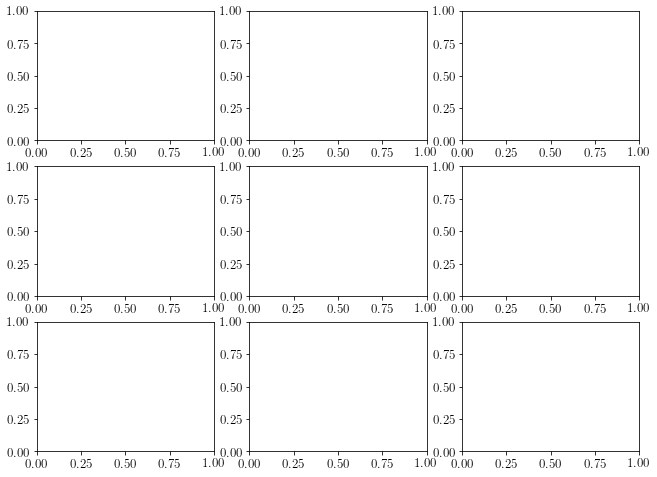

In [19]:
prods = ['MERRA','NCEP-NCAR','NCEP-DOE','UKESM','obs']

fact = 0.9
fig, axs = plt.subplots(3,3, figsize=(12*fact, 9*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for p in prods:
    
    axs[0].plot

               
### plot timeseries